In [7]:
combinedInputPath = "/mnt/SPDrive/SPGenerations/" #The path to the folder containing the tokenized and graded data. If individualInput is true, this will be ignored

individualInput = False #If true, the program will use the individual input paths below. If false, it will use the combinedInputPath above
pathToTokenizedData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Tokenizer\\"
pathToGradeData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Grader\\"

GradesTokensName = "" #Specifiy the versions (name) of the grade and token files to use. Leave blank to use the newest version

modelOutputPath = "/home/mcall/SPGenerations/Models/" #The path to the folder for the model output.

import os
def homePath(path):
    if path[0] == "~":
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

if not individualInput:
    pathToTokenizedData = os.path.join(combinedInputPath, "Tokens/")
    pathToGradeData = os.path.join(combinedInputPath, "Grades/")

if GradesTokensName == "":
    #Use newest folder for each

    #Get the newest folder for the tokens
    tokensFolders = os.listdir(pathToTokenizedData)
    tokensFolders.sort()
    pathToTokenizedData = os.path.join(pathToTokenizedData , tokensFolders[-1])

    #Get the newest folder for the grades
    gradesFolders = os.listdir(pathToGradeData)
    gradesFolders.sort()
    pathToGradeData = os.path.join(pathToGradeData,  gradesFolders[-1])
else:
    pathToTokenizedData = os.path.join(pathToTokenizedData, GradesTokensName)
    pathToGradeData = os.path.join(pathToGradeData, GradesTokensName)








In [8]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional, Input, Flatten, Concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.layers as layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model




from keras.utils import pad_sequences
import os



#Load the data
#tokenized data is in tokenizedData.pkl, has tokenizer obj in tokenizer.json

#Load the tokenizer
with open(pathToTokenizedData+ "/tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())



#Load the tokenized data
with open(pathToTokenizedData + "/tokenizedData.pkl", "rb") as f:
    tokenizedData = pickle.load(f)

#Load the grade data
#gradeData is a dict with keys as the file names and values as the grades
with open(pathToGradeData + "/grades.pkl", "rb") as f:
    gradeData = pickle.load(f)

#load the group data
#with open(pathToTokenizedData + "/tokenGroupDataframe.pkl", "rb") as f:
#    tokenizedGroupData = pickle.load(f)

combinedDF = pd.merge(tokenizedData, gradeData, on = "Path")
#combinedDF = pd.merge(combinedDF, tokenizedGroupData, on = "Path")
print (combinedDF)







                                                tokenCode  \
0       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
1       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
2       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
3       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
4       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
...                                                   ...   
180568  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   
180569  [44, 284, 28, 284, 28, 1, 28, 266, 44, 1, 28, ...   
180570  [28, 682, 44, 284, 28, 284, 28, 1, 28, 266, 44...   
180571  [44, 284, 28, 284, 28, 1, 28, 266, 44, 1, 28, ...   
180572  [28, 682, 44, 284, 28, 284, 28, 1, 28, 266, 44...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/2.py  66.000000  
2       3722273/examples/basics/linear_regression.py/3

In [9]:
rungraph = False
if rungraph:
    #chart of token length vs grade
    tokenLengths = combinedDF["tokenCode"].apply(lambda x: len(x))
    plt.scatter(tokenLengths, combinedDF["fileGrade"])
    plt.xlabel("Token Length")
    plt.ylabel("Grade")
    plt.show()


    #graph the density of the grades vs length
    count = []
    countLow = []
    countHigh = []
    for i in range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1):
        count.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].mean())
        countLow.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.25))
        countHigh.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.75))

                    

    plt.scatter(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count)
    #draw a line of best fit
    z = np.polyfit(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count, 1)
    p = np.poly1d(z)
    plt.xlabel("Token Length")
    plt.ylabel("Grade")
    plt.show()







In [10]:
#Padding

maxLen = 500
minLen = 100
#get rid of the ones that are too long
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#shorten the ones that are too long
#combinedDF["tokenCode"] = combinedDF["tokenCode"].apply(lambda x: x[:maxLen])
#combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) <= maxLen]
 

#get rid of the ones that are too short
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) > minLen]
#combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) > minLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()
#combinedDF["tokenGroupCode"] = pad_sequences(combinedDF["tokenGroupCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

print (combinedDF)

#only use 5% of the dat
#combinedDF = combinedDF.sample(frac = 0.001, random_state = 1)

#48590 



                                                tokenCode  \
0       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
1       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
2       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
3       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
4       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
...                                                   ...   
180559  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   
180561  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   
180564  [44, 422, 28, 1, 28, 266, 28, 79, 4, 24, 10, 3...   
180565  [44, 422, 28, 1, 4, 24, 10, 3, 9, 3, 4, 25, 10...   
180568  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/2.py  66.000000  
2       3722273/examples/basics/linear_regression.py/3

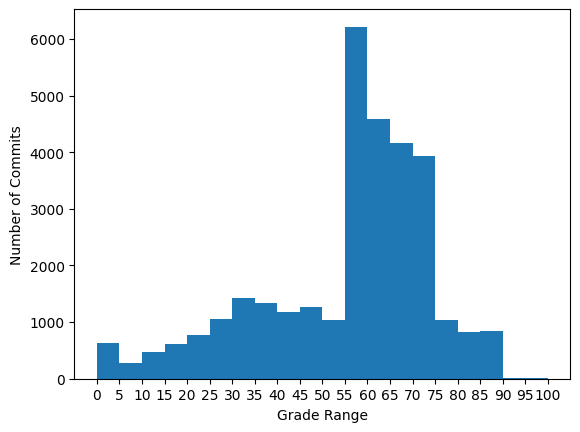

In [11]:
#create a chart of the grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()



In [15]:
from hyperopt import hp, fmin, tpe
from hyperopt import STATUS_OK
from tokenize import TokenInfo

from keras.layers import Dense, Flatten, Dropout
from keras.layers import LSTM

from keras.optimizers import Nadam, Adam
from keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_logarithmic_error, squared_hinge, hinge, categorical_hinge, logcosh,  categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy, kullback_leibler_divergence, poisson

# Define the search space for the hyperparameters
space = {
    'loss' : hp.choice('loss', ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error']),
    'batch_size': hp.quniform('batch_size', 32, 360, 32),
    'optimizer': hp.choice('optimizer', ['Adam', 'Nadam']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'activation': hp.choice('activation', ['relu', 'tanh', 'sigmoid', 'softmax', 'softplus', 'softsign', 'selu', 'elu', 'exponential']),
    'activation2' : hp.choice('activation2', ['relu', 'tanh', 'sigmoid', 'softmax', 'softplus', 'softsign', 'selu', 'elu', 'exponential']),
    'activation3' : hp.choice('activation3', ['relu', 'tanh', 'sigmoid', 'softmax', 'softplus', 'softsign', 'selu', 'elu', 'exponential']),
    'activation4' : hp.choice('activation4', ['relu', 'tanh', 'sigmoid', 'softmax', 'softplus', 'softsign', 'selu', 'elu', 'exponential']),
    }

# Define the objective function
def objective(params):
    inputTokens = layers.Input(shape=(maxLen,), dtype='int32')
    #Embedding
    embedding = layers.Embedding(tokenizer.num_words, 2048, input_length=maxLen)(inputTokens)

    #Convolutional
    convolutional = layers.Conv1D(2048, 3, activation=params['activation'])(embedding)
    convolutional = layers.GlobalMaxPooling1D()(convolutional)
    convolutional = layers.Reshape((1, 2048))(convolutional)

    #LSTM
    lstm = layers.Bidirectional(LSTM(1024, return_sequences=True))(convolutional)
    lstm = Dropout(params['dropout_rate'])(lstm)
    lstm = layers.Bidirectional(LSTM(512))(lstm)

    #Dense
    dense = layers.Flatten()(lstm)
    dense = layers.Dense(4096, activation=params['activation2'])(dense)
    dense = layers.Dense(2048, activation=params['activation3'])(dense)
    dense = layers.Dense(1, activation=params['activation4'])(dense)

    #Output
    output = dense
    model = Model(inputs=inputTokens, outputs=output)

    #Compile
    if params['optimizer'] == 'Adam':
        optimizer = Adam()
    else:
        optimizer = Nadam()

    model.compile(optimizer=optimizer, loss=params['loss'], metrics=['accuracy'])

    #Train
    history = model.fit(np.array(combinedDF["tokenCode"].tolist()), np.array(combinedDF["fileGrade"].tolist()), batch_size=int(params['batch_size']), epochs=8, validation_split=0.2, verbose=0)

    print (history.history)
    print (history.history['loss'])
    print (history.history['val_loss'])
    # Return the loss
    MSE = abs(history.history['loss'][-1])
    
    print(params, history)
    return abs(MSE)

# Run the hyperparameter search using the TPE algorithm
best = fmin(objective, space, algo=tpe.suggest, max_evals=30)
print(best)

# Get the values of the optimal parameters
best_params = hp.space_eval(space, best)
print(best_params)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

{'loss': [40872.640625, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906], 'accuracy': [0.01287553645670414, 0.012914910912513733, 0.012914910912513733, 0.012914910912513733, 0.012914910912513733, 0.012914910912513733, 0.012914910912513733, 0.012914910912513733], 'val_loss': [99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297], 'val_accuracy': [0.0007874015718698502, 0.0007874015718698502, 0.0007874015718698502, 0.0007874015718698502, 0.0007874015718698502, 0.0007874015718698502, 0.0007874015718698502, 0.0007874015718698502]}
[40872.640625, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906, 98.70851135253906]
[99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.92125701904297, 99.

AttributeError: module 'hyperopt.hp' has no attribute 'space_eval'